## Australian Vehicle Prices
### Jan Brzozowski, Jan Gębal

Projekt, którego celem było zbadanie zbioru [Australian Vehicle Prices](https://www.kaggle.com/datasets/nelgiriyewithana/australian-vehicle-prices) i klasyfikacja obiektów ze względu na cenę, korzystając z klasyfikatorów: drzewo decyzyjne i las losowy.

In [136]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

### Wstępna analiza

In [3]:
original_data = pd.read_csv("Australian Vehicle Prices.csv")
original_data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [4]:
print("\n========== original_data ==========")

# liczba obiektów
print("Liczba obiektów = ", original_data.shape[0])

# liczba atrybutów
print("Liczba atrybutów = ", original_data.shape[1])

# usunięcie danych brakujących
original_data = original_data.dropna(how="any")

print("\n========== original_data po usunięciu ==========")
# liczba obiektów
print("Liczba obiektów = ", original_data.shape[0])

# liczba atrybutów
print("Liczba atrybutów = ", original_data.shape[1])


========== original_data ==========
Liczba obiektów =  16734
Liczba atrybutów =  19

========== original_data po usunięciu ==========
Liczba obiektów =  14586
Liczba atrybutów =  19


In [5]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14586 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              14586 non-null  object 
 1   Year               14586 non-null  float64
 2   Model              14586 non-null  object 
 3   Car/Suv            14586 non-null  object 
 4   Title              14586 non-null  object 
 5   UsedOrNew          14586 non-null  object 
 6   Transmission       14586 non-null  object 
 7   Engine             14586 non-null  object 
 8   DriveType          14586 non-null  object 
 9   FuelType           14586 non-null  object 
 10  FuelConsumption    14586 non-null  object 
 11  Kilometres         14586 non-null  object 
 12  ColourExtInt       14586 non-null  object 
 13  Location           14586 non-null  object 
 14  CylindersinEngine  14586 non-null  object 
 15  BodyType           14586 non-null  object 
 16  Doors              145

##### Wnioski
Po usunięciu nieprawidłowych wartości mamy 14586 wierszy w naszym dataframe'ie. Każdy obiekt ma 19 atrybutów. Wszystkie atrybuty, oprócz 'Year' w naszym zbiorze danych są typu 'object' i będziemy musieli zamienić je na dane numeryczne (float/int).

### Analiza poszczególnych atrybutów

#### Brand

In [6]:
print(f'liczba wszystki marek = {len(original_data.loc[:, "Brand"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "Brand"].value_counts()[:20]}')
print(f'udział 20 najpopularniejszych marek: {100 * original_data.loc[:, "Brand"].value_counts()[:20].sum() / original_data.loc[:, "Brand"].value_counts().sum()}%')

liczba wszystki marek = 64
najpopularniejsze wartości:
 Toyota           2261
Hyundai          1150
Mazda            1073
Holden           1024
Ford              968
Mitsubishi        960
Nissan            837
Volkswagen        785
Kia               765
Mercedes-Benz     531
Subaru            520
Audi              432
BMW               402
Honda             321
Jeep              286
MG                278
Suzuki            266
Land              197
Isuzu             175
GWM               174
Name: Brand, dtype: int64
udział 20 najpopularniejszych marek: 91.90319484437131%


##### Wnioski
'Brand' jest atrybutem kategorycznym nominalnym ze stosunkowo dużą liczbą unikalnych wartości. Na początku zdecydowaliśmy się zmniejszyć liczbę marek do 20 najpopularniejszych jako, że i tak stanowią one 91,9% procent wszystkich samochodów. By użyć ten atrybut w naszym modelu musimy go również zakodować. Zdecydowaliśmy się na 'target encoding' jako, że nie tworzy on dużej liczby rzadkich kolumn jak 'one-hot-encoding', ale również nie wprowadza fałszywego uporządkowania jak 'label encoding'. Problemem może być 'overfitting', który jest mitygowany poprzez średnią ważoną średniej wartości danej klasy i średniej dla wszystkich klas.

#### Year

In [7]:
original_data.loc[:, 'Year'].describe()

count    14586.000000
mean      2016.237899
std          4.923525
min       1978.000000
25%       2013.000000
50%       2017.000000
75%       2020.000000
max       2023.000000
Name: Year, dtype: float64

##### Wnioski
'Year' jest atrybutem ilościowym. Dla atrybutów ilościowych zdecydowaliśmy się usunąć wartości skrajne tj. większe niż średnia+3\*odchylenie i mniejsze niż średnia-3\*odchylenie.

#### Model

In [8]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "Model"].unique())}')
print(f'najpopularniejsze modele:\n {original_data.loc[:, "Model"].value_counts()[:20]}')

liczba unikalnych wartości = 646
najpopularniejsze modele:
 Hilux          407
Ranger         372
Landcruiser    362
Corolla        356
I30            350
RAV4           333
Triton         285
Commodore      272
X-Trail        242
Cerato         226
Outlander      223
Navara         223
3              221
Camry          218
CX-5           204
Rover          197
Tiguan         193
Colorado       186
Tucson         182
Grand          180
Name: Model, dtype: int64


##### Wnioski
'Model' jest kolejnym atrybutem kategorycznym nominalnym. Ma aż 646 unikalnych wartości. Nie byliśmy pewni jak potraktować ten atrybut, więc stworzyliśmy dwa warianty:
<ol>
    <li>
        Całkowite usunięcie atrybutu. <br>
        Motywacja: duża liczba unikalnych wartości sprawia, że atrybut nie będzie niósł ze sobą zbyt dużej wiedzy dla modelu. 
    </li>
    <li>
        Połączenie atrybutu 'Brand' i 'Model' <br>
        Motywacja: 'Model' może nieść ze sobą jakąś informację. Należy jednak go połączyć z 'Brand', ponieważ dwie różne marki samochodów mogą mieć tak samo nazywający się model.
    </li>
</ol>

#### Car/Suv

In [9]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "Car/Suv"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "Car/Suv"].value_counts()[:20]}')

liczba unikalnych wartości = 245
najpopularniejsze wartości:
 SUV                                 5921
Hatchback                           2361
Ute / Tray                          2067
Sedan                               1897
Wagon                                566
Commercial                           305
Coupe                                254
Convertible                          100
Rockdale Mazda New                    42
Alto Blacktown MG                     37
Dominelli GWM                         28
Alto North Shore MG                   22
Audi Alto Artarmon New Cars           22
Liverpool Volkswagen New Cars         21
Liverpool Mazda New Cars              20
Kedron Haval & Great Wall Online      20
Hillcrest GWM HAVAL                   19
Springwood GWM HAVAL                  18
Sydney City Volkswagen New            17
Brighton Mazda New & Demo             17
Name: Car/Suv, dtype: int64


##### Wnioski
'Car/Suv' jest niepotrzebnym atrybutem. Występują w nim opisy typu samochodu, które są zawarte w atrybucie 'BodyType', jak i zbędne  informacje o dealerach samochodowych sprzedających dany samochód (prawdopodobnie). 

#### Title

In [10]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "Title"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "Title"].value_counts()[:20]}')

liczba unikalnych wartości = 7094
najpopularniejsze wartości:
 2019 Hyundai I30 Active                      60
2020 Kia Cerato S                            52
2020 Hyundai Kona Active (fwd)               38
2020 Hyundai I30 Active                      35
2021 Toyota Corolla Ascent Sport Hybrid      28
2018 Toyota Hilux SR (4X4)                   27
2018 Hyundai I30 Active                      26
2017 Toyota Hilux SR (4X4)                   25
2019 Toyota Hilux SR (4X4)                   22
2019 Kia Cerato S                            21
2019 Mitsubishi ASX ES (2WD)                 21
2019 Toyota Corolla Ascent Sport (hybrid)    21
2019 Toyota Camry Ascent (hybrid)            21
2019 Kia Carnival S                          21
2021 MG HS Core                              21
2020 Subaru Forester 2.5I (awd)              19
2018 Toyota Hilux Workmate                   18
2016 Hyundai Accent Active                   18
2021 Hyundai I30                             17
2011 Holden Commodore SV6

##### Wnioski
Kolejny zbędny atrybut. Informacje z tego atrybutu zawarte są w innych atrybutach.

#### Used or New

In [11]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "UsedOrNew"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "UsedOrNew"].value_counts()}')

liczba unikalnych wartości = 3
najpopularniejsze wartości:
 USED    13517
NEW       633
DEMO      436
Name: UsedOrNew, dtype: int64


##### Wnioski
Atrybut kategoryczny porządkowy, mający 3 unikatowe wartości. Zostanie on zakodowany metodą 'label encoding' dzięki temu, że możemy powiedzieć, że USED(1) < DEMO(2) < NEW(3). 

#### Transmission

In [12]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "Transmission"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "Transmission"].value_counts()}')

liczba unikalnych wartości = 3
najpopularniejsze wartości:
 Automatic    12855
Manual        1699
-               32
Name: Transmission, dtype: int64


##### Wnioski
Atrybut posiada 3 unikatowe wartości. Usunięte zostaną obiekty z atrybutem równym '-' jako, że są to prawdopodobnie nieuzupełnione dane lub dane dotyczące aut elektrycznych, które postanowiliśmy usunąć ze względu na zbyt małą liczbę obiektów. Pozostałe wartości zostaną zakodowane binarnie: 'Manual' = 0 i 'Automatic' = 1

#### Engine

In [13]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "Engine"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "Engine"].value_counts()[:50]}')

liczba unikalnych wartości = 91
najpopularniejsze wartości:
 4 cyl, 2 L      3843
4 cyl, 2.5 L    1604
4 cyl, 2.4 L     812
4 cyl, 1.8 L     702
4 cyl, 1.5 L     683
6 cyl, 3 L       680
4 cyl, 2.8 L     581
4 cyl, 1.6 L     554
4 cyl, 3 L       520
4 cyl, 2.2 L     507
4 cyl, 1.4 L     498
6 cyl, 3.6 L     368
5 cyl, 3.2 L     357
6 cyl, 3.5 L     354
4 cyl, 1.2 L     253
4 cyl, 2.3 L     203
6 cyl, 4 L       172
3 cyl, 1 L       153
4 cyl, 1.3 L     147
8 cyl, 4.5 L     142
6 cyl, 3.3 L     115
4 cyl, 2.7 L     103
0 L               90
6 cyl, 2.7 L      84
8 cyl, 6 L        79
4 cyl, 2.1 L      78
8 cyl, 5 L        73
3 cyl, 1.5 L      73
4 cyl, 3.2 L      71
8 cyl, 6.2 L      68
6 cyl, 3.7 L      52
8 cyl, 5.7 L      49
6 cyl, 3.8 L      46
8 cyl, 4 L        45
3 cyl, 1.3 L      40
3 cyl, 1.2 L      34
6 cyl, 3.2 L      28
6 cyl, 4.2 L      25
6 cyl, 2.5 L      24
4 cyl, 1.9 L      22
5 cyl, 2.5 L      21
8 cyl, 4.4 L      21
8 cyl, 4.7 L      19
5 cyl, 2.4 L      17
8 cyl, 6.4 L   

##### Wnioski
Atrybut 'Engine' zostanie rozdzielony na dwa atrybuty ilościowe: 'Cylinders' oraz 'Displacement'. Następnie z obu atrybutów zostaną usunięte niepożądane wartosci (np. dla 0L jako, że są to najprawdopodobniej auta elektryczne), potem usuniemy skrajne tj. większe niż średnia+3\*odchylenie i mniejsze niż średnia-3\*odchylenie.

#### Drive Type

In [14]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "DriveType"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "DriveType"].value_counts()[:50]}')

liczba unikalnych wartości = 5
najpopularniejsze wartości:
 Front    6551
4WD      3089
AWD      2960
Rear     1984
Other       2
Name: DriveType, dtype: int64


##### Wnioski
Atrybut posiadający 5 unikalnych wartości. Objekty z atrybutem o wartości 'Other' zostaną usnięte z powodu zbyt małej liczby występowania. Następnie atrybut zakodujemy za pomocą metody 'one hot encoding', co możemy zrobić z powodu małej liczby unikalnych wartości. Należy zauważyć, że '4WD' to nie to samo co 'AWD'. 
<br>
4WD – to napęd 4x4, w którym standardowo napędzana jest jedna oś (najczęściej tylna); kierowca sam musi dołączyć napęd drugiej przyciskiem lub dźwignią,
<br>
AWD – jest napędem na wszystkie koła; może to być napęd stały lub dołączany automatycznie (w zwykłych warunkach drogowych napędzane są dwa koła, a w momencie utraty przyczepności napęd trafia też do kół drugiej osi).
<br>
Na podstawie informacji ze strony [https://www.jaguar.pl/naped/naped-awd-jak-dziala-uf24](https://www.jaguar.pl/naped/naped-awd-jak-dziala-uf24g)

#### Fuel Type

In [15]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "FuelType"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "FuelType"].value_counts()[:50]}')

liczba unikalnych wartości = 8
najpopularniejsze wartości:
 Unleaded    6267
Diesel      4354
Premium     3075
Hybrid       615
-            167
Electric      90
LPG           14
Leaded         4
Name: FuelType, dtype: int64


##### Wnioski
Atrybut posiadający 8 unikalnych wartości. Obiekty z atrybutem o wartości '-', 'LPG', 'Leaded' i 'Electric' zostaną usunięte z powodu zbyt małej liczby występowania. Następnie atrybut zostanie zakodowany metodą one-hot-encoding, co możemy zrobić dzięki małej liczbie unikalnych wartości.

#### Fuel Consumption

In [16]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "FuelConsumption"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "FuelConsumption"].value_counts()[:20]}')

liczba unikalnych wartości = 152
najpopularniejsze wartości:
 7.4 L / 100 km    703
7.9 L / 100 km    506
7.3 L / 100 km    468
8.1 L / 100 km    436
7.5 L / 100 km    400
7.6 L / 100 km    398
7.2 L / 100 km    396
8.5 L / 100 km    353
8 L / 100 km      352
6.9 L / 100 km    337
6 L / 100 km      299
8.3 L / 100 km    295
6.6 L / 100 km    285
7 L / 100 km      260
8.2 L / 100 km    258
6.4 L / 100 km    257
8.8 L / 100 km    256
9 L / 100 km      255
8.9 L / 100 km    251
6.7 L / 100 km    251
Name: FuelConsumption, dtype: int64


##### Wnioski
Atrybut zostanie zamieniony na wartość numeryczną (liczba przed L). Usunięte zostaną wartości 0.0 (prawdopodbnie auta elektryczne)oraz wartości ekstremalne.

#### Kilometres

In [17]:
original_data[original_data['Kilometres'] != '-'].loc[:, 'Kilometres'].astype(int).describe()

count     14481.000000
mean      99921.339203
std       78175.956338
min           1.000000
25%       40868.000000
50%       84910.000000
75%      146495.000000
max      526162.000000
Name: Kilometres, dtype: float64

##### Wnioski
Z atrybutu 'Kilometres' muszą zostać usunięte wartości '-' i być zmieniony na float/int. Następnie usuniemy wartości ekstremalne.

#### Colour Ext/Int

In [18]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "ColourExtInt"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "ColourExtInt"].value_counts()[:20]}')

column = pd.DataFrame()
column['ColourExterior'] = original_data['ColourExtInt'].str.extract(r'^(.+)/')
column = column[column['ColourExterior'] != '- ']
print(f'udział 10 najpopularniejszych kolorów: {100 * column.loc[:,"ColourExterior"].value_counts().head(10).sum() / column.loc[:,"ColourExterior"].value_counts().sum() }')

liczba unikalnych wartości = 714
najpopularniejsze wartości:
 White / -                2503
White / Black            1550
Silver / -                990
Grey / -                  843
Black / -                 780
Grey / Black              735
Blue / -                  638
Silver / Black            622
White / Grey              592
Black / Black             548
Red / -                   467
Blue / Black              446
Red / Black               328
- / -                     323
Silver / Grey             186
Grey / Grey               169
Blue / Grey               112
White / Cloth             104
Red / Grey                 92
White / Black Leather      84
Name: ColourExtInt, dtype: int64
udział 10 najpopularniejszych kolorów: 98.10353304769264


##### Wnioski
Atrybut zostanie podzielony na 'ColourExterior' i 'ColourInterior'. Atrybut 'ColourInterior' zostanie usunięty z powodu zbyt dużej liczby brakujących danych, a z 'ColourExterior' weźmiemy 10 najpopularniejszych wartości jako, że stanowią 98,1% wszystkich samochodów. Następnie zakodujemy wartości 'ColourExterior' metodą 'target encoding' jako, że nie tworzy ona dużej liczby rzadkich kolumn jak 'one-hot-encoding', ale również nie wprowadza fałszywego uporządkowania jak 'label encoding'. Problemem może być 'overfitting', który jest mitygowany poprzez średnią ważoną średniej wartości danej klasy i średniej dla wszystkich klas. Nie jesteśmy pewni co do przydatności tego atrybutu, co zostanie zbadane.

#### Location

In [19]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "Location"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "Location"].value_counts()[:20]}')

liczba unikalnych wartości = 594
najpopularniejsze wartości:
 Minchinbury, NSW         503
Liverpool, NSW           251
Blacktown, NSW           236
Hoppers Crossing, VIC    219
Ringwood, VIC            208
Bentley, WA              205
Cardiff, NSW             194
Berwick, VIC             184
Wangara, WA              183
Alexandria, NSW          163
Osborne Park, WA         157
Phillip, ACT             156
Kedron, QLD              153
Artarmon, NSW            141
Victoria Park, WA        138
Southport, QLD           131
Brookvale, NSW           128
Granville, NSW           126
Fyshwick, ACT            120
Five Dock, NSW           119
Name: Location, dtype: int64


##### Wnioski
'Location' jest atrybutem kategorycznym nominalnym. Zakodujemy jego wartości metodą 'target encoding' jako, że nie tworzy ona dużej liczby rzadkich kolumn jak 'one-hot-encoding', ale również nie wprowadza fałszywego uporządkowania jak 'label encoding'. Problemem może być 'overfitting', który jest mitygowany poprzez średnią ważoną średniej wartości danej klasy i średniej dla wszystkich klas. Nie jesteśmy pewni co do przydatności tego atrybutu, co zostanie zbadane.

#### Cylinders in Engine

In [20]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "CylindersinEngine"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "CylindersinEngine"].value_counts()[:20]}')

liczba unikalnych wartości = 9
najpopularniejsze wartości:
 4 cyl     11203
6 cyl      1982
8 cyl       585
5 cyl       399
3 cyl       309
0 L          90
12 cyl       11
2 cyl         4
10 cyl        3
Name: CylindersinEngine, dtype: int64


##### Wnioski
Zbędny atrybut, mamy te dane wcześniej zapisane.

#### Body Type

In [21]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "BodyType"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "BodyType"].value_counts()[:20]}')

liczba unikalnych wartości = 10
najpopularniejsze wartości:
 SUV             6670
Hatchback       2450
Ute / Tray      2207
Sedan           1944
Wagon            606
Commercial       321
Coupe            258
Convertible      101
People Mover      15
Other             14
Name: BodyType, dtype: int64


##### Wnioski
Atrybut o 10 unikalnych wartościach. Wartości 'Other' i 'People Mover' zostaną usunięte z powodu zbyt małej liczby występowania. Następnie zakodujemy jego wartości metodą 'target encoding' jako, że nie tworzy ona dużej liczby rzadkich kolumn jak 'one-hot-encoding', ale również nie wprowadza fałszywego uporządkowania jak 'label encoding'. Problemem może być 'overfitting', który jest mitygowany poprzez średnią ważoną średniej wartości danej klasy i średniej dla wszystkich klas. 

#### Doors

In [22]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "Doors"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "Doors"].value_counts()[:20]}')

liczba unikalnych wartości = 4
najpopularniejsze wartości:
  4 Doors    10948
 5 Doors     2477
 2 Doors      971
 3 Doors      190
Name: Doors, dtype: int64


##### Wnioski
Atrybut zostanie zamieniony na wartość numeryczną.

#### Seats

In [23]:
print(f'liczba unikalnych wartości = {len(original_data.loc[:, "Seats"].unique())}')
print(f'najpopularniejsze wartości:\n {original_data.loc[:, "Seats"].value_counts()[:20]}')

liczba unikalnych wartości = 12
najpopularniejsze wartości:
  5 Seats     11088
 7 Seats      1767
 4 Seats       642
 2 Seats       538
 8 Seats       267
 3 Seats       241
 6 Seats        22
 14 Seats       11
 9 Seats         3
 11 Seats        3
 12 Seats        3
 22 Seats        1
Name: Seats, dtype: int64


##### Wnioski
Atrybut zostanie zamieniony na wartość numeryczną i usunięte zostaną wartości ekstremalne.

#### Price

In [24]:
original_data[original_data['Price'] != 'POA'].loc[:, 'Price'].astype(int).describe()

count     14551.000000
mean      34980.246306
std       29031.113506
min          88.000000
25%       18990.000000
50%       28990.000000
75%       42755.000000
max      649880.000000
Name: Price, dtype: float64

##### Wnioski
Jest to atrybut decyzyjny. Zostaną usuniętę wartości 'POA'. Atrybut zostanie zamieniony na klasy według kodu:
<br>
thresholds = [5000 * x for x in range(1, 15)]
<br>
def helper_Price(x):<br>
    > x = int(x)<br>
    > for ix, threshold in enumerate(thresholds):<br>
        > > if x < threshold:<br>
            > > > return ix<br>
    > return 14

### Wyczyszczenie danych

In [25]:
def one_hot_encode_column(df, column_name, prefix=None):
    column_data = df[column_name]
    encoded_data = pd.get_dummies(column_data, columns=[column_name], prefix=prefix)
    df = pd.concat([df, encoded_data], axis=1)
    df = df.drop(columns = column_name)
    return df

In [26]:
def remove_extreme_values(df, column_name):
    df = df[df[column_name] > df[column_name].mean() - 3 * df[column_name].std()]
    df = df[df[column_name] < df[column_name].mean() + 3 * df[column_name].std()]
    return df

In [27]:
def target_encode_column(df, column):
    df = df.copy()
    m = len(df[column].unique())
    means = df.groupby(column)['Price'].mean()
    counts = df.groupby(column)['Price'].count()
    overall_mean = df["Price"].mean()

    df[column] = (df[column].map(means) * df[column].map(counts) + overall_mean * m) / (df[column].map(counts) + m)
    return df

In [28]:
def clean_Brand(df):
    df = df[~df['Brand'].isin(df.loc[:,'Brand'].value_counts().index[20:])]
    return target_encode_column(df, 'Brand')

In [29]:
def merge_Brand_Model(df):
    df = df[~df['Brand'].isin(df.loc[:,'Brand'].value_counts().index[20:])]
    df.loc[:,'Brand_Model'] = df.loc[:,'Brand'] + "_" + df.loc[:,'Model']
    df = df.drop(columns=['Brand', 'Model'])
    return target_encode_column(df, 'Brand_Model')

In [30]:
def clean_Year(df):
    df['Year'] = df['Year'].astype(int)
    return remove_extreme_values(df, 'Year')

In [31]:
def helper_UsedOrNew(x):
    if x == 'USED':
        return 1
    elif x == 'DEMO':
        return 2
    elif x == 'NEW':
        return 3
    else:
        raise Exception("Unknown state")
        
def clean_UsedOrNew(df):
    df['UsedOrNew'] = df['UsedOrNew'].apply(lambda x: helper_UsedOrNew(x))
    return df

In [32]:
def clean_Transmission(df):
    df = df.copy()
    df = df[df['Transmission'] != '-']
    df['Transmission'].replace({'Manual': 0, 'Automatic': 1}, inplace=True)
    return df

In [33]:
def clean_Engine(df):
    df['Cylinders'] = df['Engine'].str.extract(r'(\b\d+)').astype(int)
    df['Displacement'] = df['Engine'].str.extract(r'\b\d+\b.*?(\d+\.\d+|\d+)\b').astype(float)
    df = df.dropna(how="any")
    df = df.drop(columns='Engine')
    df = remove_extreme_values(df, 'Cylinders')
    df = remove_extreme_values(df, 'Displacement')
    return df

In [34]:
def clean_DriveType(df):
    df = df.copy()
    df = df[df['DriveType'] != 'Other']
    return one_hot_encode_column(df, 'DriveType', None)

In [35]:
def clean_FuelType(df):
    df = df.copy()
    df = df[~df['FuelType'].isin(['-', 'LPG', 'Leaded', 'Electric'])]
    return one_hot_encode_column(df, 'FuelType', None)

In [36]:
def clean_FuelConsumption(df):
    df = df.copy()
    df['FuelConsumption'] = df['FuelConsumption'].str.extract(r'(\b\d+\.\d+|\d+)').astype(float)
    df = df[df['FuelConsumption'] != 0.0]
    return remove_extreme_values(df, 'FuelConsumption')

In [37]:
def clean_Kilometres(df):
    df = df.copy()
    df = df[df['Kilometres'] != '-']
    df['Kilometres'] = df['Kilometres'].astype(int)
    return remove_extreme_values(df, 'Kilometres')

In [38]:
def clean_ColourExtInt(df):
    df['ColourExterior'] = df['ColourExtInt'].str.extract(r'^(.+)/')
    df = df[df['ColourExterior'] != '- ']
    df = df[~df['ColourExterior'].isin(df.loc[:,'ColourExterior'].value_counts().index[10:])]
    df = df.drop(columns='ColourExtInt')
    return target_encode_column(df, 'ColourExterior')

In [39]:
def clean_Location(df):
    return target_encode_column(df, 'Location')

In [40]:
def clean_BodyType(df):
    df = df.copy()
    df = df[~df['BodyType'].isin(['Other', 'People Mover'])]
    return target_encode_column(df, 'BodyType')

In [41]:
def clean_Doors(df):
    df['NumOfDoors'] = df['Doors'].str.extract(r'(\b\d+)').astype(int)
    df = df.drop(columns='Doors')
    return df

In [42]:
def clean_Seats(df):
    df['NumOfSeats'] = df['Seats'].str.extract(r'(\b\d+)').astype(int)
    df = df.drop(columns='Seats')
    return remove_extreme_values(df, 'NumOfSeats')

In [43]:
thresholds = [5000 * x for x in range(1, 15)]

def helper_Price(x):
    x = int(x)
    for ix, threshold in enumerate(thresholds):
        if x < threshold:
            return ix
    return 14

def clean_Price(df):
    df = df.copy()
    df = df[df['Price'] != 'POA']
    df['Price'] = df['Price'].apply(lambda x: helper_Price(x))
    return df

In [44]:
def clean_data_without_Model(df):
    cleaned_data = df.drop(columns=['Model', 'Title', 'Car/Suv', 'CylindersinEngine'])
    cleaned_data = clean_Price(cleaned_data)
    cleaned_data = clean_Brand(cleaned_data)
    cleaned_data = clean_Year(cleaned_data)
    cleaned_data = clean_UsedOrNew(cleaned_data)
    cleaned_data = clean_Transmission(cleaned_data)
    cleaned_data = clean_Engine(cleaned_data)
    cleaned_data = clean_DriveType(cleaned_data)
    cleaned_data = clean_FuelType(cleaned_data)
    cleaned_data = clean_FuelConsumption(cleaned_data)
    cleaned_data = clean_Kilometres(cleaned_data)
    cleaned_data = clean_ColourExtInt(cleaned_data)
    cleaned_data = clean_Location(cleaned_data)
    cleaned_data = clean_BodyType(cleaned_data)
    cleaned_data = clean_Doors(cleaned_data)
    cleaned_data = clean_Seats(cleaned_data)
    return cleaned_data

In [45]:
def clean_data_merge_Brand_Model(df):
    cleaned_data = df.drop(columns=['Title', 'Car/Suv', 'CylindersinEngine'])
    cleaned_data = clean_Price(cleaned_data)
    cleaned_data = merge_Brand_Model(cleaned_data)
    cleaned_data = clean_Year(cleaned_data)
    cleaned_data = clean_UsedOrNew(cleaned_data)
    cleaned_data = clean_Transmission(cleaned_data)
    cleaned_data = clean_Engine(cleaned_data)
    cleaned_data = clean_DriveType(cleaned_data)
    cleaned_data = clean_FuelType(cleaned_data)
    cleaned_data = clean_FuelConsumption(cleaned_data)
    cleaned_data = clean_Kilometres(cleaned_data)
    cleaned_data = clean_ColourExtInt(cleaned_data)
    cleaned_data = clean_Location(cleaned_data)
    cleaned_data = clean_BodyType(cleaned_data)
    cleaned_data = clean_Doors(cleaned_data)
    cleaned_data = clean_Seats(cleaned_data)
    return cleaned_data

In [46]:
cleaned_data_wo_M = clean_data_without_Model(original_data)
cleaned_data_BM = clean_data_merge_Brand_Model(original_data)

C:\Users\janbb\AppData\Local\Temp\ipykernel_14464\2687718097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'Brand_Model'] = df.loc[:,'Brand'] + "_" + df.loc[:,'Model']


### Analiza danych

In [49]:
numerical_columns = ['Year', 'Cylinders', 'Displacement', 'FuelConsumption', 'Kilometres', 'NumOfDoors', 'NumOfSeats']
drive_types = ['AWD', '4WD', 'Front', 'Rear']
fuel_types = ['Diesel', 'Hybrid', 'Premium', 'Unleaded']

In [50]:
def show_numerical_column(cleaned_data, atr): 
    for cl in [0, 4, 7, 9, 14]:
        sns.histplot(cleaned_data.loc[cleaned_data.Price == cl, atr], label=cl)
    plt.legend()

In [51]:
def show_one_hot_columns(cleaned_data, atrs):
    ax = plt.gca()
    for i, atr in enumerate(atrs):
        data = cleaned_data[cleaned_data.loc[:, atr] == 1]["Price"].value_counts().sort_index()
        ax.bar(data.index + i * 0.2, data.values, width=0.2, label=atr)
    plt.xlabel("Price")
    plt.ylabel("Count")
    ax.set_xticks(cleaned_data["Price"].unique() + 0.3)
    ax.set_xticklabels(cleaned_data["Price"].unique())
    plt.legend()
    plt.show()

In [52]:
def show_label_columns(cleaned_data, column):
    ax = plt.gca()
    for i, atr in enumerate(cleaned_data.loc[:, column].unique()):
        data = cleaned_data[cleaned_data.loc[:, column] == atr]["Price"].value_counts().sort_index()
        ax.bar(data.index + i * 0.2, data.values, width=0.2, label=atr)
    plt.xlabel("Price")
    plt.ylabel("Count")
    ax.set_xticks(cleaned_data["Price"].unique() + 0.3)
    ax.set_xticklabels(cleaned_data["Price"].unique())
    plt.legend()
    plt.show()

<Axes: xlabel='Price', ylabel='Count'>

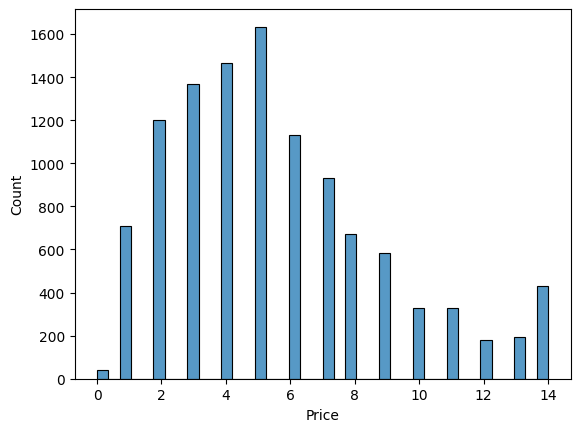

In [53]:
sns.histplot(cleaned_data_wo_M.Price)

<b>Wnioski</b>
<br><br>
Analizując histogram ilości aut w zależności od kategorii cenowej możemy zauważyć, że większość pojazdów znajduje się w średniej kategorii cenowej. Zdecydowanie większa częstość pojazdów w kategorii 14 względem 13 czy 12 wynika z większego zakresu cenowego 70 tys i więcej. Najwięcej aut występuje w kategorii 25 tys do 30 tys. Natomiast najmniej w kategorii do 5 tys.

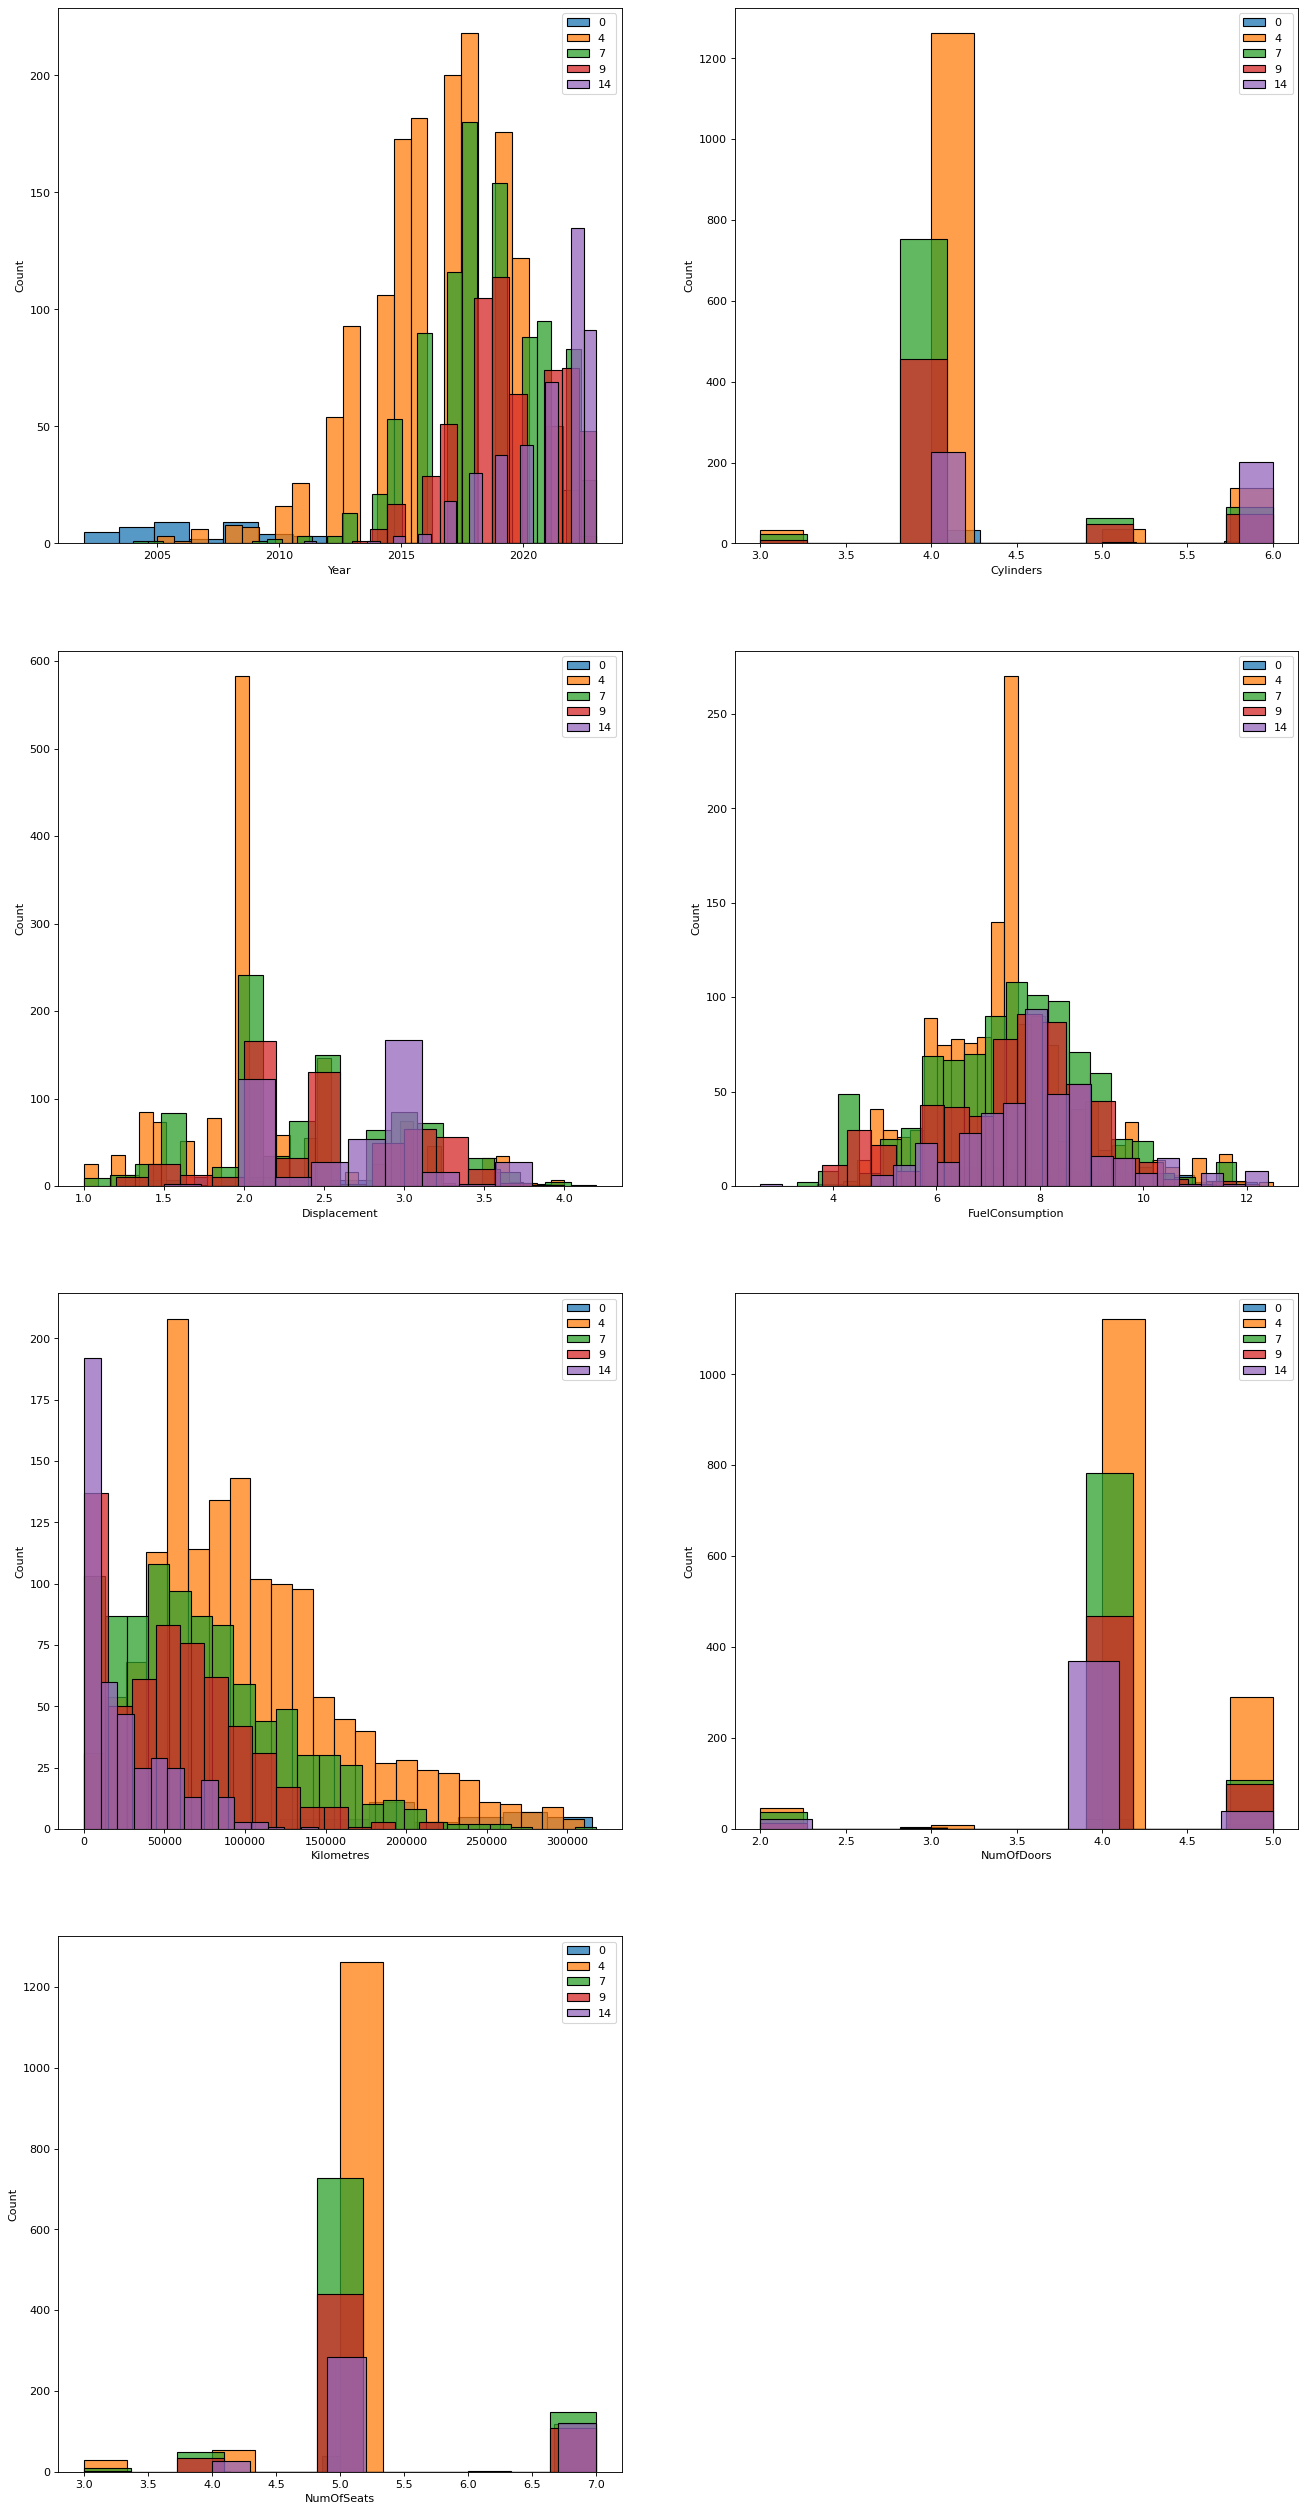

In [54]:
plt.figure(figsize=(20,40), dpi= 80)
for idx, column in enumerate(numerical_columns):
    plt.subplot(4,2,idx+1)
    show_numerical_column(cleaned_data_wo_M, column)

<b>Wnioski</b>
<br><br>
Analizując histogram roku produkcji w zależności od ilości pojazdów z zaznaczonymi kolorami wybranymi przedziałami cenowymi w celu lepszej widoczności możemy zauważyć, że większość aut została wyprodukowana w 2015 roku lub później. Auta z mniejszym rocznikiem
to w zdecydowanej większości auta z niskiej kategorii cenowej. Większość aut z wyższej kategorii cenowej to nowe auta.
<br><br>
Analizując histogram ilości cylindrów przygotowany w ten sam sposób jak poprzedni możemy zauważyć, że 4 cylindry to liczba przeważająca dla aut z prawie każdej klasy gdzie odstępstwem jest klasa 14 gdzie rozkład jest w miarę równy. Możemy stwierdzić, że liczba cylindrów równa 6 jest bardziej standardowa dla aut wyższej klasy. Natomiast liczby 3 i 5 wzkazują nam, że cylindry w takiej liczbie rzadko występują w jakiejkolwiek klasie.
<br><br>
Analizując wykres pojemności silnika możemy zauważyć, że jest on mocno różnowartościowy. Dla większości kategori aut pojemność 2.0 jest najczęściej występującą. Pojemności mniejsze niż 2.0 są charakterystyczne dla aut średniej i niskiej klasy natomiast, nie występują tam prawie auta wyższej klasy.
<br><br>
Analizując wykres zużycia paliwa możemy zauważyć, że wykres jest zdecydowanie bardziej zrównoważony, przypomina nieco krzywą gaussa. Spalanie większości aut znajduje się w przedziale od 6 do 10. Możemy stwierdzić że spalanie nie jest mocno związane z klasą cenową pojazdów.
<br><br>
Analizując wykres ilości drzwi możemy dojść do wniosku, że większość pojazdów ma 4 badź 5 drzwi natomiast inne ilości są zdecydowanie rzadzej występujące. Możemy stwierdzić, że liczba drzwi nie jest mocno związana z kategorią cenową.
<br><br>
Analizując wykres ilości foteli możemy dojść do podobnych wniosków co w poprzednim przypadku. Większość aut posiada 5 foteli oraz ilość foteli nie jest mocno związana z kategorią cenową.
<br><br>
Analizując wykres przebiegu możemy stwierdzić, że im wyższa kategoria cenowa auta tym mniejszy przebieg. Zdecydowana większość aut mało używanych to te z wyższej kategorii cenowej.

<Axes: >

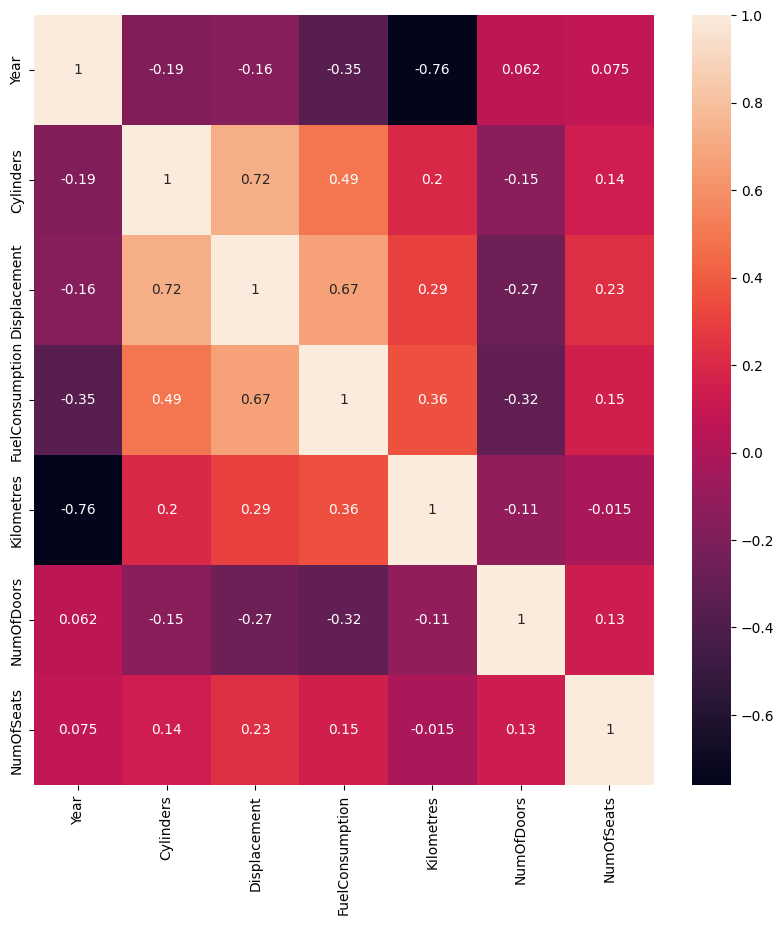

In [55]:
correlations = cleaned_data_wo_M[numerical_columns].corr()
plt.figure(figsize=(10, 10), dpi=100)
sns.heatmap(correlations, annot=correlations)

<b>Wnioski</b>
<br><br>
Macierz korelacji pozwala nam stwierdzić parę ważnych faktów, pojemność silnika związana jest z ilością cylindrów jak również ze spalaniem. Co jak najbardziej sensownie odzwierciedla rzeczywistą relację.
<br><br>
Możemy również zauważyć wysoką korelację (warto zaznaczyć że jest ujemna) rocznika i przebiegu, która pozwala nam zauważyć odwrotną proporcjonalność przebiegu do rocznika co również ma logiczny sens. Im wcześniej wyprodukowano auto tym dłużej mogło ono poruszać się na drogach.

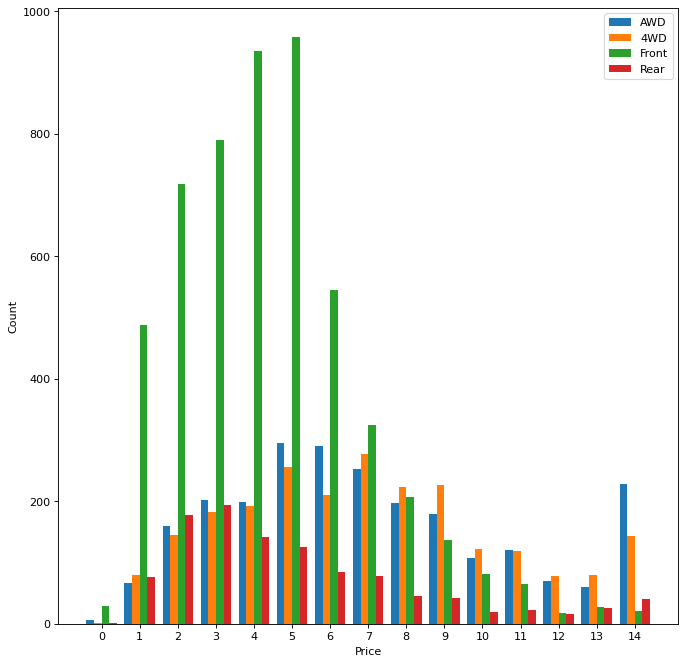

In [56]:
plt.figure(figsize=(10,10), dpi= 80)
show_one_hot_columns(cleaned_data_wo_M, drive_types)

<b>Wnioski</b>
<br><br>
Na podstawie wykresu ilości pojazdów w danej klasie cenowej w zależności od rodzaju napędu, możemy stwierdzić że auta z napędem na przód całkowicie dominują przedział cenowy od 0 do 6 (czyli od 0 do 35 tys). Auta z napędem na tył może nie dominują tak jak te z napędem na przód natomiast ich występowanie jest również najwyższe dla podobnego przedziału cenowego. Auta z napędem na 4 i na wszystkie koła oscylują w podobnych wartościach i są większą częścią pojazdów w kategoriach od 7 do 14( od 35 tys wzwyż) niż w niższych przedziałach. Rodzaje te zaczynają dominować w kategoriach od 11 do 14 (od 55 tys wzwyż).

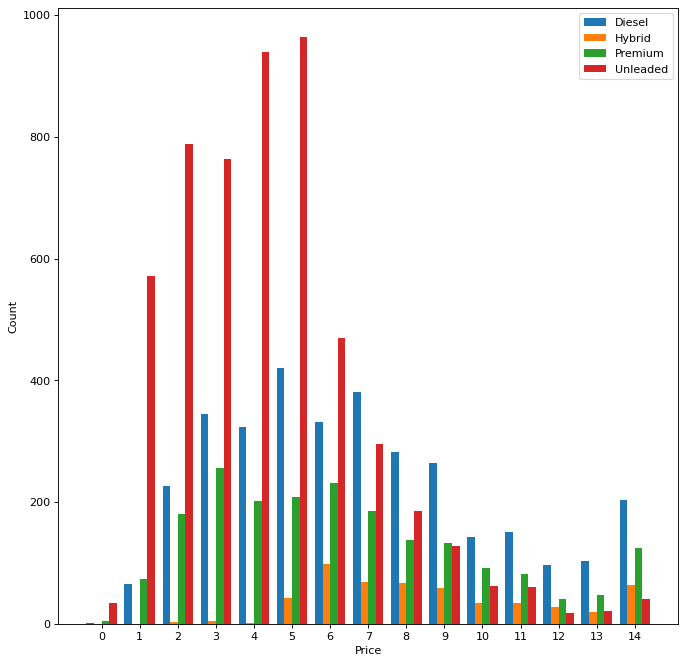

In [57]:
plt.figure(figsize=(10,10), dpi= 80)
show_one_hot_columns(cleaned_data_wo_M, fuel_types)

<b>Wnioski</b>
<br><br>
Analizując wykres ilości aut w danej kategori cenowej w zależności od rodzaju paliwa moażemy stwierdzić, że auta z niskiej półki cenowej charakteryzują się używaniem paliwa bezołowiowego. Natomiast pojazdy od kategori 6 ( od 30 tys) zaczynają bardzej się rozróżniać względem rodzaju paliwa, Diesel i Premium zaczynają zajmować większą część zbioru. Auta zasilane paliwem hybrydowym prawie nie występują w przedziale od 0 do 4 ( od 0 do 25 tys), co jest charakterystyczne dla pojazdów wyższej klasy. Paliwo typu Diesel występuje szeroko w każdej klasie natomiast dla klas od 8 ( od 40 tys) włącznie stanowi większość.

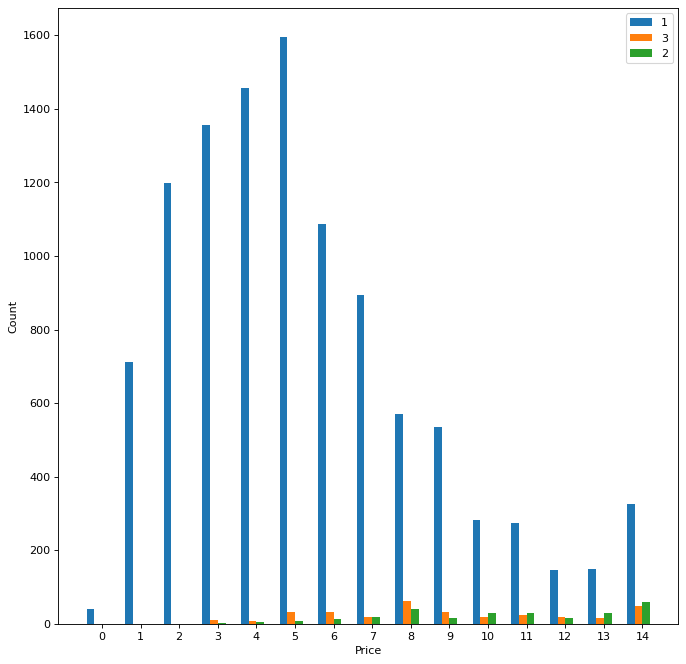

In [58]:
plt.figure(figsize=(10,10), dpi= 80)
show_label_columns(cleaned_data_wo_M, 'UsedOrNew')

<b>Wnioski</b>
<br><br>
Auta typu demo, czyli auta udostępnianie przez sprzedawcę w celu umożliwnia np. przetestowania pojazdu przez klienta są tańsze niż nowe pojazdy. Analizując wykres możemy łatwo zauważyć, że całkowicie dominują auta używane. Dla kategorii 0 , 1 i 2 (do 15 tys) nie występują żadne pojazdy typu demo bądź nowe. W kategori od 3 do 9 (od 20 do 50 tys) auta nowe częściej występują niż auta demonstracyjne, dla aut w kategorii od 11 do 14 (od 55 tys) jest odwrotnie z wyjątkiem klasy 12 (od 60 do 65 tys).

In [59]:
cleaned_data_BM.loc[:,'BodyType'].describe()

count    11200.000000
mean         5.590252
std          1.056662
min          3.857076
25%          4.556463
50%          6.264860
75%          6.264860
max          6.795546
Name: BodyType, dtype: float64

In [60]:
cleaned_data_BM.loc[:,'Location'].describe()

count    11200.000000
mean         5.588876
std          0.276993
min          4.428503
25%          5.544705
50%          5.621160
75%          5.710147
max          6.083955
Name: Location, dtype: float64

In [61]:
cleaned_data_BM.loc[:,'ColourExterior'].describe()

count    11200.000000
mean         5.608124
std          0.454989
min          3.564974
25%          5.364451
50%          5.857262
75%          5.880599
max          6.067107
Name: ColourExterior, dtype: float64

In [62]:
cleaned_data_BM.loc[:,'Brand_Model'].describe()

count    11200.000000
mean         5.727278
std          0.485581
min          4.945748
25%          5.414166
50%          5.675116
75%          5.942018
max          7.873510
Name: Brand_Model, dtype: float64

In [63]:
cleaned_data_wo_M.loc[:,'Brand'].describe()

count    11200.000000
mean         5.712195
std          1.294865
min          3.640683
25%          4.701954
50%          5.299241
75%          6.786441
max          9.635359
Name: Brand, dtype: float64

<b>Wnioski</b>
<br><br>
Możemy zauważyć, że zakodowane atrybuty 'Brand_Model', 'ColourExterior' i 'Location' mają niewielkie odchylenie stardardowe(< 0.5 ), co może być spowodowane przez dużą liczbę unikalnych wartości. Możemy domyślać się, że nie będą one aż tak przydatne w procesie klasyfikacji.

### Klasyfikacja

#### Porównanie wyników dla danych bez atrybutu 'Model' i z połączonym atrybutem 'Brand' oraz 'Model'

In [64]:
def get_splits(df):
    df_price = df['Price']
    df = df.drop(columns='Price')
    return train_test_split(df, df_price, test_size=0.3, random_state=42)

In [64]:
datasets = [cleaned_data_wo_M, cleaned_data_BM]
n_runs = 100

In [65]:
results = [0, 0]
for ix, dataset in enumerate(datasets):
    x_train, x_test, y_train, y_test = get_splits(dataset)
    for run in range(n_runs):
        model = tree.DecisionTreeClassifier(random_state=run)
        model.fit(x_train, y_train)
        results[ix] += model.score(x_test, y_test)

print( f'cleaned_data_wo_M = {100 * results[0] / n_runs}%')
print( f'cleaned_data_BM = {100 * results[1] / n_runs}%')

cleaned_data_wo_M = 41.96279761904761%
cleaned_data_BM = 42.157142857142865%


In [66]:
results = [0, 0]
for ix, dataset in enumerate(datasets):
    x_train, x_test, y_train, y_test = get_splits(dataset)
    for run in range(n_runs):
        model = ensemble.RandomForestClassifier(n_jobs=-1, random_state=run)
        model.fit(x_train, y_train)
        results[ix] += model.score(x_test, y_test)
    
print( f'cleaned_data_wo_M = {100 * results[0] / n_runs}%')
print( f'cleaned_data_BM = {100 * results[1] / n_runs}%')

cleaned_data_wo_M = 50.412797619047616%
cleaned_data_BM = 50.4794642857143%


##### Wnioski
Jak widać dla drzew decyzyjnych i lasów losowych dwa zbiory dają podobną trafność wyników. Jednak w obu przypadkach zbiór z połączoną marką i modelem daje odrobinę lepsze wyniki niż zbiór bez modelu. Oznacza to, że model niesie za sobą istotną informację, której nie należy pomijać.

#### Dobranie hiperparametrów dla drzewa decyzyjnego

In [83]:
# analizowane warianty hiperparametrów
criterions = ['gini', 'entropy']
splitters = ['best', 'random']
min_samples_splits = [2, 4, 8, 16, 32]
min_samples_leaves = [1, 2, 4, 8, 16, 32]
n_runs = 10

In [67]:
# klasa pomocnicza
class Result:
    def __init__(self, criterion, splitter, min_samples_split, min_samples_leaf, n_estimators=1):
        self.criterion = criterion
        self.splitter = splitter
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_estimators = n_estimators
        self.result = 0.0
    
    def increment_result(self, new_result):
        self.result += new_result

In [85]:
results_tree = []
x_train, x_test, y_train, y_test = get_splits(cleaned_data_BM)
for criterion in criterions:
    for splitter in splitters:
        for min_samples_split in min_samples_splits:
            for min_samples_leaf in min_samples_leaves:
                result = Result(criterion, splitter, min_samples_split, min_samples_leaf)
                for run in range(n_runs):
                    model = tree.DecisionTreeClassifier(criterion=criterion, splitter=splitter, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=run)
                    model.fit(x_train, y_train)
                    result.increment_result(model.score(x_test, y_test))
                results_tree.append(result)
                result = None

In [86]:
best_criterion = {'gini': 0, 'entropy': 0,}
best_splitter = {'best': 0, 'random': 0}
best_min_samples_splits = {2: 0, 4: 0, 8: 0, 16: 0, 32: 0}
best_min_samples_leaves = {1: 0, 2: 0, 4: 0, 8: 0, 16: 0, 32: 0}

for result in results_tree:
    best_criterion[result.criterion] += result.result
    best_splitter[result.splitter] += result.result
    best_min_samples_splits[result.min_samples_split] += result.result
    best_min_samples_leaves[result.min_samples_leaf] += result.result

##### Wnioski

In [87]:
for criterion in best_criterion:
    print(f'avg for {criterion} = {100*best_criterion[criterion]/(60*10)}%')

avg for gini = 40.78407738095238%
avg for entropy = 41.011855158730164%


Jak widzimy kryterium 'gini' daje gorsze wyniki niż 'entropy'. Nie uwzględniamy kryterium 'log_loss' jako, że jest to, to samo kryterium co 'entropy'.

In [88]:
for splitter in best_splitter:
    print(f'avg for {splitter} = {100*best_splitter[splitter]/(60*10)}%')

avg for best = 41.59672619047619%
avg for random = 40.19920634920635%


Możemy zauważyć, że wybieranie najlepszego 'splittera' jest lepsze od losowania.

In [89]:
for min_samples_split in best_min_samples_splits:
    print(f'avg for {min_samples_split} = {100*best_min_samples_splits[min_samples_split]/(24*10)}%')

avg for 2 = 40.9375%
avg for 4 = 40.877852182539684%
avg for 8 = 40.9874751984127%
avg for 16 = 41.1281001984127%
avg for 32 = 40.55890376984127%


Możemy zauważyć, że gdy minimalna ilość próbek w węźle drzewa jest mała (2, 4, 8) drzewo uzuskuje wyniki gorsze niż gdy minimalna ilość próbek w węźle drzewa wynosi 16. Najgorszy wynik otrzymujemy dla 32. Jest to prawdopodobnie spowodowane tym, że dla niskich wartości drzewo nie potrafi uogólniać swojej wiedzy, a jedynie zapamiętuje wyniki. Dla zbyt dużej wartości drzewo zbyt uogólnia przez co traci niezbędne informacje.

In [90]:
for min_samples_leaf in best_min_samples_leaves:
    print(f'avg for {min_samples_leaf} = {100*best_min_samples_leaves[min_samples_leaf]/(20*10)}%')

avg for 1 = 42.04077380952381%
avg for 2 = 41.69642857142857%
avg for 4 = 41.97261904761905%
avg for 8 = 41.51502976190476%
avg for 16 = 39.744047619047606%
avg for 32 = 38.4188988095238%


Możemy zauważyć, że w ogólności im mniejsza ilość próbek jaka może zostać w węźle po przeprowadzeniu testu tym lepiej. Nie spodziewaliśmy się takiego wyniku. Zakładaliśmy, że ten hiperparametr będzie miał podobne właściwości co min_samples_split, czyli najlepsza wartość będzie 'gdzieś w środku', co pozwoli drzewu lepiej uogólniać swoją wiedzę.

In [92]:
results_tree.sort(key=lambda x: x.result, reverse=True)
for i in range(3):
    result = results_tree[i]
    print(f'{result.criterion}, {result.splitter}, {result.min_samples_split}, {result.min_samples_leaf} = {100 * result.result / n_runs}')

entropy, best, 16, 4 = 44.47619047619047
entropy, best, 16, 2 = 44.333333333333336
entropy, best, 16, 1 = 44.330357142857146


Najlepsze wyniki daje kryterium = 'entropy', splitter = 'best', min_samples_spilt = 16 i co ciekawe min_samples_leaf = 4, a nie min_samples_leaf = 1 na co wskazywałaby wcześniejsza analiza. Należy jedenak zauważyć, że wyniki są bardzo zbliżone.

#### Dobranie hiperparametrów dla lasu losowego

In [77]:
criterions = ['gini', 'entropy']
min_samples_splits = [2, 4, 8, 16]
min_samples_leaves = [1, 2, 4, 8, 16]
ns_estimators = [25, 50, 100, 200, 400]
n_runs = 10

In [78]:
results_forest = []
x_train, x_test, y_train, y_test = get_splits(cleaned_data_BM)
for criterion in criterions:
    for min_samples_split in min_samples_splits:
        for min_samples_leaf in min_samples_leaves:
            for n_estimators in ns_estimators:
                result = Result(criterion=criterion, splitter=None, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)
                for run in range(n_runs):
                    model = ensemble.RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=run, n_jobs=-1)
                    model.fit(x_train, y_train)
                    result.increment_result(model.score(x_test, y_test))
                results_forest.append(result)
                result = None

In [93]:
best_criterion = {'gini': 0, 'entropy': 0,}
best_n_estimators = {25:0, 50:0, 100:0, 200:0, 400:0}
best_min_samples_splits = {2: 0, 4: 0, 8: 0, 16: 0}
best_min_samples_leaves = {1: 0, 2: 0, 4: 0, 8: 0, 16: 0}

for result in results_forest:
    best_criterion[result.criterion] += result.result
    best_min_samples_splits[result.min_samples_split] += result.result
    best_min_samples_leaves[result.min_samples_leaf] += result.result
    best_n_estimators[result.n_estimators] += result.result

##### Wnioski

In [95]:
for criterion in best_criterion:
    print(f'{criterion} = {100*best_criterion[criterion]/(100*10)}%')

gini = 47.81458333333333%
entropy = 47.941279761904724%


Wyniki są analogiczne do wyników drzewa decyzyjnego. Kreterium 'entropy' jest lepsze niż 'gini'.

In [88]:
for n_estimators in best_n_estimators:
    print(f'{n_estimators} = {100*best_n_estimators[n_estimators]/(40*10)}%')

25 = 47.047544642857126%
50 = 47.715476190476174%
100 = 48.086830357142865%
200 = 48.2469494047619%
400 = 48.292857142857144%


Można zauważyć zależność, że im większa liczba drzew w lesie tym lepszy wynik. Jest to logiczny wniosek, dzięki większej ilości 'głosujących' możemy uzyskać lepsze uogólnienie.

In [89]:
for min_samples_splits in best_min_samples_splits:
    print(f'{min_samples_splits} = {100*best_min_samples_splits[min_samples_splits]/(50*10)}%')

2 = 48.08988095238094%
4 = 48.12494047619047%
8 = 47.97047619047618%
16 = 47.326428571428565%


Wyniki odbiegają od wyników w drzewie decyzyjnym. Tam najlepsza wartość min_samples_split wynosiła 16. Dla lasów losowych mniejsza wartość daje lepsze wyniki. W naszym przypadku 4. Jest to prawdopodobnie spowodowane tym, że las sam w sobie dzięki dużej ilości drzew jest w stanie dobrze uogólniać, a jeśli do tego zwiększymy uogólnianie dla poszczególnych drzew możemy utracić część informacji.

In [90]:
for min_samples_leaves in best_min_samples_leaves:
    print(f'{min_samples_leaves} = {100*best_min_samples_leaves[min_samples_leaves]/(40*10)}%')

1 = 49.816294642857144%
2 = 49.3921875%
4 = 48.44962797619047%
8 = 46.889285714285705%
16 = 44.8422619047619%


Tutaj również im mniejsza wartość min_samples_leaf tym lepiej. Analogiczna sytuacja jak dla min_samples_split.

In [97]:
results_forest.sort(key=lambda x: x.result, reverse=True)
for i in range(3):
    result = results_forest[i]
    print(f'{result.criterion}, {result.n_estimators}, {result.min_samples_split}, {result.min_samples_leaf} = {100 * result.result / n_runs}')

entropy, 400, 2, 1 = 51.14880952380951
gini, 400, 2, 1 = 51.056547619047606
entropy, 400, 4, 1 = 51.03571428571428


Najlepsze wyniki daje kryterium = 'entropy', n_estimators = 400, min_samples_spilt = 2 i min_samples_leaf = 1, co pokrywa się z wcześniejszą analizą. Należy jedenak zauważyć, że wyniki są bardzo zbliżone.

#### Wizualizacja dokładności modeli

accuracy = 44.49404761904761%
[[  1  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  4 135  62   6   1   0   0   0   0   0   0   0   0   0   0]
 [  1  70 203  71  12   2   0   0   0   0   0   0   0   0   0]
 [  0  11  91 204  81  28   2   4   2   0   0   0   0   0   0]
 [  0   0  19  72 220  90  21   8   0   0   0   0   0   0   0]
 [  0   0   4  26 101 244  65  22   2   2   0   0   0   0   0]
 [  0   0   0   6  39  93 119  48  10  13   3   2   1   0   0]
 [  0   1   0   0  11  31  69 110  42  19   3   3   2   1   1]
 [  0   0   0   3   5   7  30  54  52  34   9   3   4   1   2]
 [  0   0   0   0   5   4   9  36  29  64  23  11   6   2   2]
 [  0   0   0   0   0   0   5   6  10  27  21  14   4   4   5]
 [  0   0   0   0   1   1   4   6   6  14  11  16   4   5  12]
 [  0   0   0   0   1   0   0   6   5   4   7  16   7   8  10]
 [  0   0   0   0   0   0   1   1   2   1   9  11   7  16  16]
 [  0   0   0   0   1   0   3   3   4   3   9  13   7   8  83]]


<Axes: >

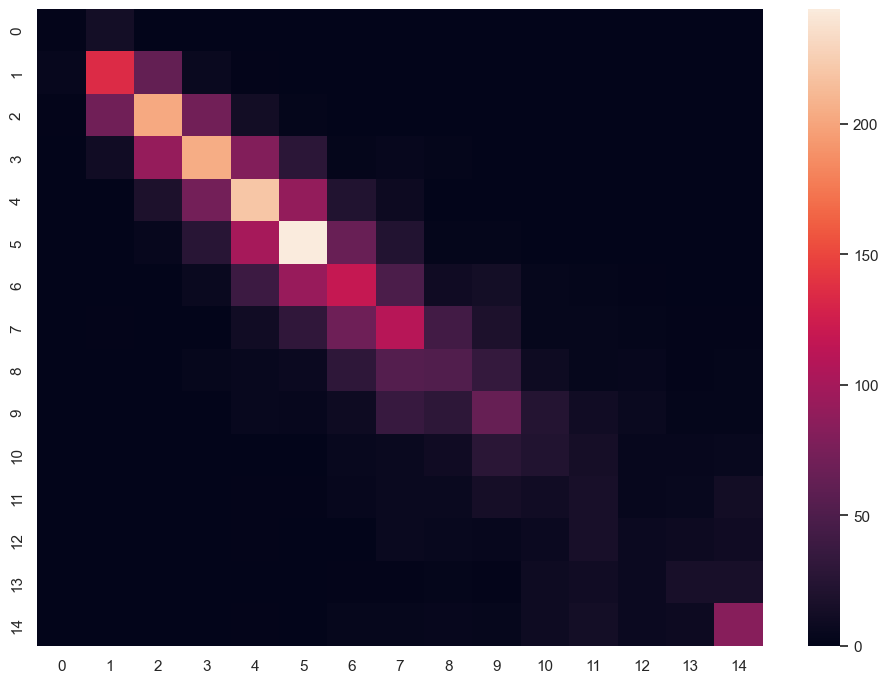

In [132]:
x_train, x_test, y_train, y_test = get_splits(cleaned_data_BM)
model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_split=16, min_samples_leaf=4, random_state=42)
model.fit(x_train, y_train)
print(f'accuracy = {100*model.score(x_test, y_test)}%')
print(confusion_matrix(y_test, model.predict(x_test)))
sns.heatmap(confusion_matrix(y_test, model.predict(x_test)))

accuracy = 51.36904761904761%
[[  0  14   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 143  59   6   0   0   0   0   0   0   0   0   0   0   0]
 [  0  37 242  75   4   1   0   0   0   0   0   0   0   0   0]
 [  0   3  86 251  68  14   1   0   0   0   0   0   0   0   0]
 [  0   0   9  86 220 103  11   1   0   0   0   0   0   0   0]
 [  0   0   1  13  75 292  65  18   2   0   0   0   0   0   0]
 [  0   0   1   5  11 109 139  49  10   9   0   1   0   0   0]
 [  0   0   0   1   2  34  68 111  54  21   1   1   0   0   0]
 [  0   0   0   0   2   8  14  57  78  33   9   2   1   0   0]
 [  0   0   0   0   2   1   3  32  43  68  23  12   1   1   5]
 [  0   0   0   0   0   0   1   6  14  25  27  17   1   3   2]
 [  0   0   0   0   0   3   3   2   5  10  15  24   4   3  11]
 [  0   0   0   0   0   2   0   2   2   3   7  19  10  10   9]
 [  0   0   0   0   0   0   0   0   2   0   3   7  11  20  21]
 [  0   0   0   0   0   0   2   0   2   1   4   7   7  10 101]]


<Axes: >

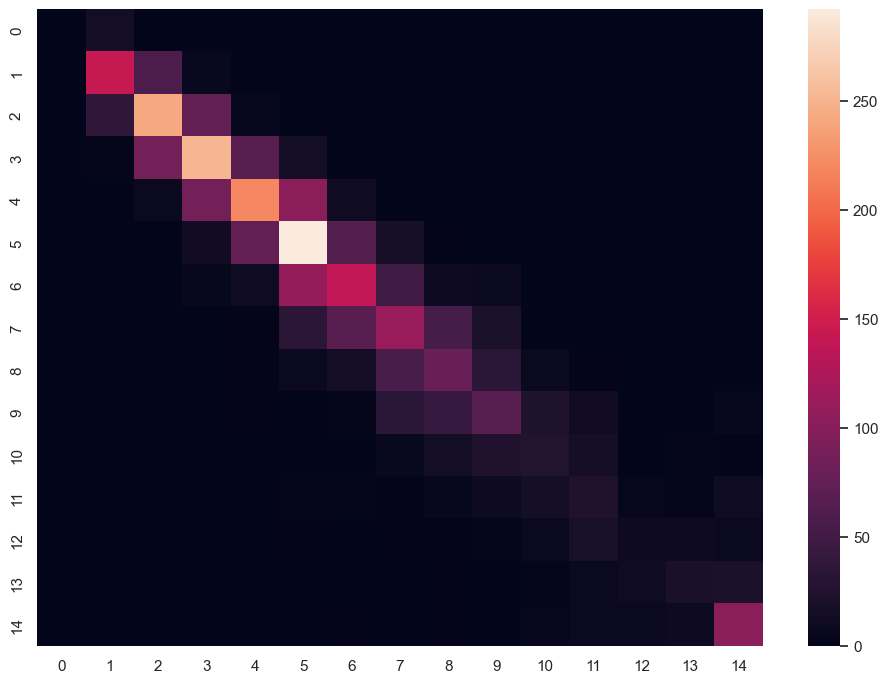

In [134]:
x_train, x_test, y_train, y_test = get_splits(cleaned_data_BM)
model = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=400, min_samples_split=2, min_samples_leaf=1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)
print(f'accuracy = {100*model.score(x_test, y_test)}%')
print(confusion_matrix(y_test, model.predict(x_test)))
sns.heatmap(confusion_matrix(y_test, model.predict(x_test)))

##### Wnioski
Jak widzimy las losowy osiąga znacznie lepsze wyniki od drzewa decyzyjnego, dzięki temu, że jest w stanie lepiej uogólniać. Nasze modele najczęsciej mylą klasy z sąsiadującymi klasami. Ma to sens, jeśli weźmiemy pod uwagę fakt, że sąsiadujące klasy są najbliżej cenowo.

#### Zbadanie przydatności atrybutów

<Axes: >

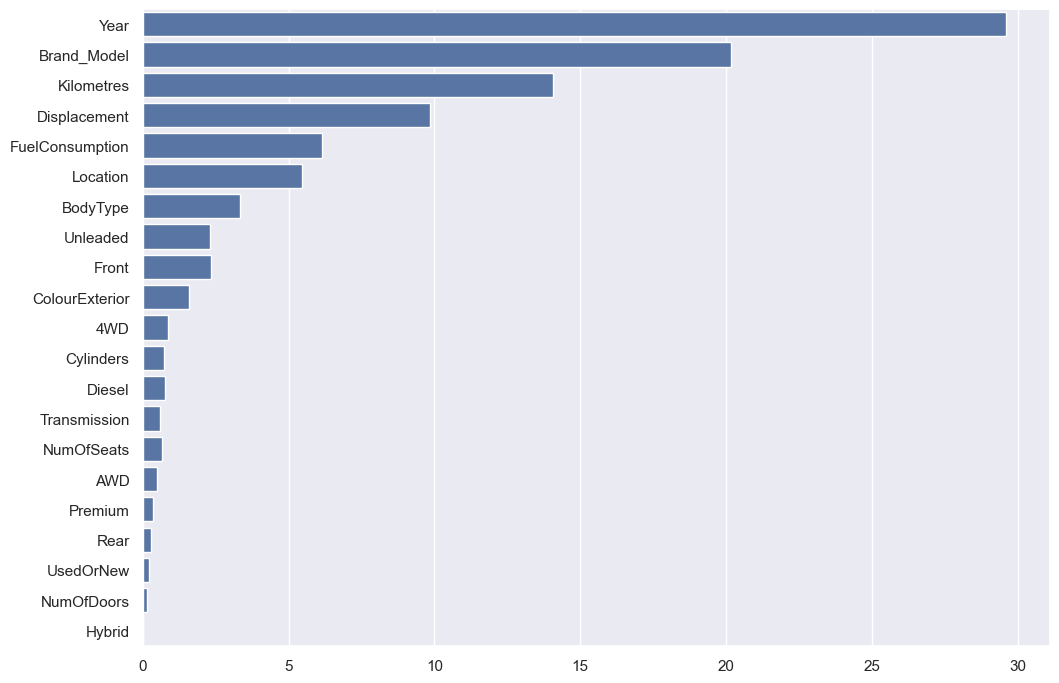

In [120]:
x_train, x_test, y_train, y_test = get_splits(cleaned_data_BM)
results = {}
n_runs=100
for run in range(n_runs):
    model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_split=16, min_samples_leaf=4, random_state=run)
    model.fit(x_train, y_train)

    feature_importances = model.feature_importances_
    sorted_indices = feature_importances.argsort()[::-1]
    sorted_feature_names = model.feature_names_in_[sorted_indices]
    sorted_importances = feature_importances[sorted_indices]
    for ix, name in enumerate(sorted_feature_names):
        if name not in results:
            results[name] = sorted_importances[ix]
        else:
            results[name] += sorted_importances[ix]


sns.barplot(results, orient='h')

<Axes: >

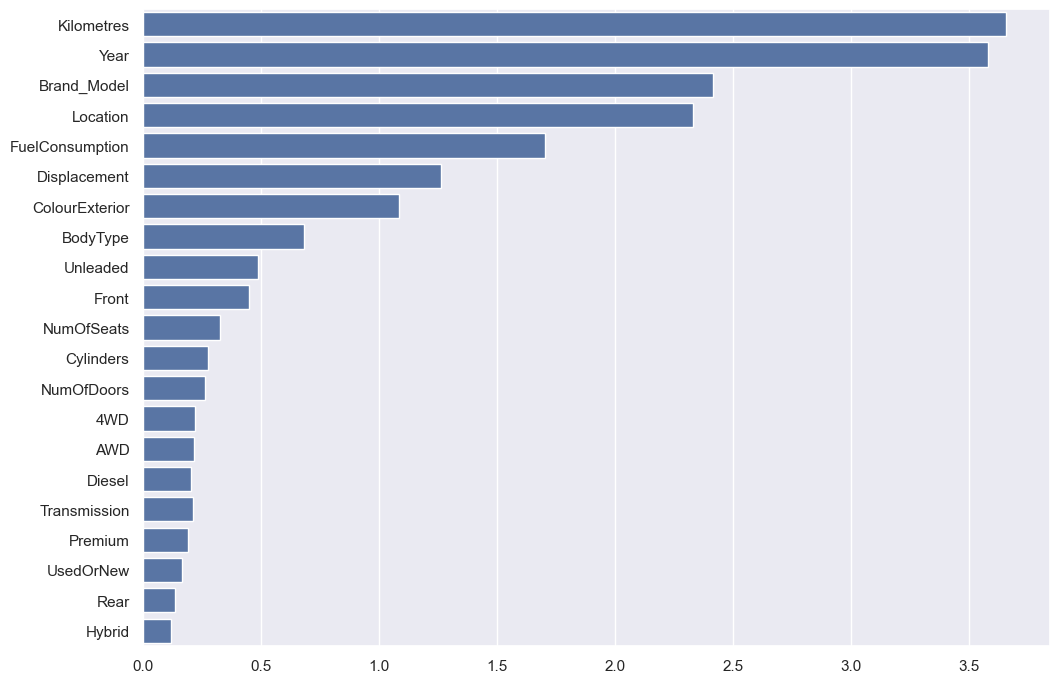

In [123]:
x_train, x_test, y_train, y_test = get_splits(cleaned_data_BM)
results = {}
n_runs=20
for run in range(n_runs):
    model = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=400, min_samples_split=2, min_samples_leaf=1, random_state=run, n_jobs=-1)
    model.fit(x_train, y_train)

    feature_importances = model.feature_importances_
    sorted_indices = feature_importances.argsort()[::-1]
    sorted_feature_names = model.feature_names_in_[sorted_indices]
    sorted_importances = feature_importances[sorted_indices]
    for ix, name in enumerate(sorted_feature_names):
        if name not in results:
            results[name] = sorted_importances[ix]
        else:
            results[name] += sorted_importances[ix]


sns.barplot(results, orient='h')

<b>Wnioski</b>
<br>
Jak widzimy dla obu rodzajów klasyfikatorów najważniejszymi atrybutami są:
<ul>
    <li>Year</li>
    <li>Brand_Model</li>
    <li>Kilometres</li>
    <li>Displacement</li>
    <li>Fuel Consumption</li>
    <li>Location</li>
    <li>Body Type</li>
    <li>Unleaded</li>
    <li>Front</li>
    <li>Colour Exterior</li>
</ul>
Zdziwiła nas tak wysoka pozycja 'Location' i 'ColourExterior'. Myśleliśmy, że te kategorie nie będą aż tak przydatne przy klasyfikacji. Nie spodziewaliśmy się również, tak niskiej pozycji atrybutu 'UsedOrNew'. Możliwe, że wynika to z jego korelacji z 'Year' i 'Kilometres', co sprawia, że jest zbędny.

In [126]:
datasets = [cleaned_data_BM, cleaned_data_BM.copy().drop(columns=['NumOfSeats', 'Cylinders', 'NumOfDoors', '4WD', 'AWD', 'Diesel', 'Transmission', 'Premium', 'UsedOrNew', 'Rear', 'Hybrid'])]
n_runs=10

In [127]:
results = [0, 0]
for ix, dataset in enumerate(datasets):
    x_train, x_test, y_train, y_test = get_splits(dataset)
    for run in range(n_runs):
        model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_split=16, min_samples_leaf=4, random_state=run)
        model.fit(x_train, y_train)
        results[ix] += model.score(x_test, y_test)


print(f'oryginalne dane = {100*results[0]/n_runs}')
print(f'uproszczone dane = {100*results[1]/n_runs}')

oryginalne dane = 44.47619047619047
uproszczone dane = 42.31249999999999


In [128]:
results = [0, 0]
for ix, dataset in enumerate(datasets):
    x_train, x_test, y_train, y_test = get_splits(dataset)
    for run in range(n_runs):
        model = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=400, min_samples_split=2, min_samples_leaf=1, random_state=run, n_jobs=-1)
        model.fit(x_train, y_train)
        results[ix] += model.score(x_test, y_test)


print(f'oryginalne dane = {100*results[0]/n_runs}')
print(f'uproszczone dane = {100*results[1]/n_runs}')

oryginalne dane = 51.14880952380951
uproszczone dane = 50.041666666666664


##### Wnioski
Dokładność modeli na uproszczonych danych jest gorsza, co jest oczywiste z powodu utraty dużej części informacji. Należy jednak zwrócić uwagę, że wyniki nie różnią się znacząco, a usunęliśmy aż 11 z 21 atrybutów, co pokazuje że możemy poświęcić odrobinę dokładności dla dużych zysków pamięciowych i obliczeniowych.